In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

Učitati skup podataka *Fashion MNIST* i ispisati broj i veličinu slika u skupu za obučavanje i skupu za testiranje.

In [2]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

len(train_dataset), train_dataset[0][0].shape, len(test_dataset), test_dataset[0][0].shape

(60000, torch.Size([1, 28, 28]), 10000, torch.Size([1, 28, 28]))

Nacrtati prvih $9$ slika iz test skupa, u mreži $3 \times 3$. Kao naslov svake slike postaviti ime klase kojoj slika pripada.

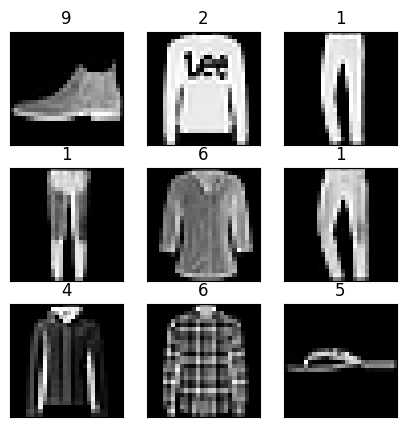

In [3]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_dataset[i][0].numpy().reshape(28,28), cmap='gray')
    plt.title(test_dataset[i][1])
plt.show()

Napraviti potpuno povezanu neuronsku mrežu sa sledećom arhitekturom:
- Sloj za ravnanje (Flatten)
- Potpuno povezani sloj sa $64$ neurona i ReLu aktivacionom funkcijom
- Potpuno povezani sloj sa brojem neurona jednakim broju klasa i softmax aktivacionom funkcijom

In [4]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(28*28, 64)
        self.layer2 = nn.Linear(64, 10)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.Softmax(1)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        return x

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        # backpropagation - racunanje gradijenta
        loss.backward()
        # x_new = x - lr * grad
        optimizer.step()
        # necemo da sabiramo sve gradijente
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn, device):
    model.eval() # ne evaluira model, samo stavlja model u eval rezim - dropout i batchnorm nisu aktivni
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy - dve klase
                preds = outputs > 0 # (izlazi > 0 -> klasa 1, izlazi <= 0 -> klasa 0)
                num_same += sum(preds == y).item()
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1) # maks po dimenziji 1 jer je outputs.shape = (batch_size, num_classes)
                num_same += sum(indices == y).item()
        return total_loss / len(dataloader.dataset), num_same / len(dataloader.dataset)

Obučiti model - postaviti veličinu paketa (batch size) na $64$, broj epoha na $10$.

Iskoristiti $20\%$ trening podataka za validaciju.

In [6]:
model = Net()

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

epochs = 10
history = []
for epoch in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    history.append(test_loop(test_loader, model, loss_fn, device))

In [7]:
n = len(history)
loss = [0 for i in range(n)]
accuracy = [0 for i in range(n)]
for i in range(n):
    loss[i], accuracy[i] = history[i]

Nacrtati grafik promene funkcije greške kroz epohe na skupu za obučavanje i za validaciju.

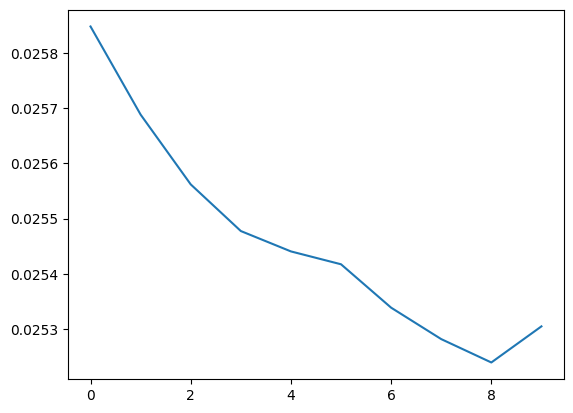

In [8]:
plt.plot(range(10), loss[:], '-')

Nacrtati grafik promene tačnosti kroz epohe na skupu za obučavanje i za validaciju.

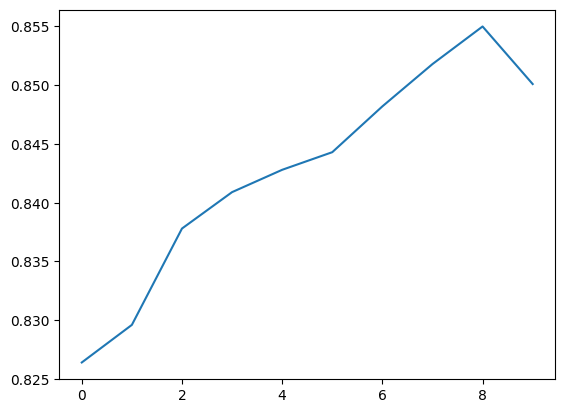

In [9]:
plt.plot(range(10), accuracy[:], '-')

Nacrtati istih $9$ instanci kao na početku. Sada pored stvarne klase, dodati i predviđenu klasu u naslov.

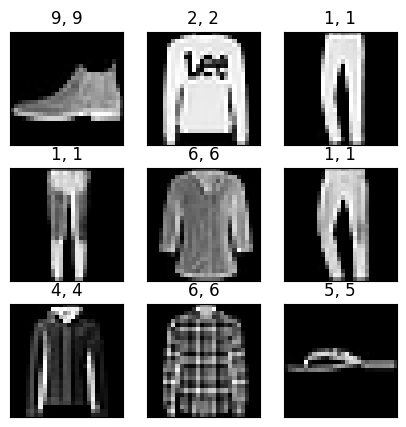

In [10]:
test_dataloader = DataLoader(test_dataset, batch_size=1)
plt.figure(figsize=(5,5))
for i, (X, y) in enumerate(test_dataloader):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_dataset[i][0].numpy().reshape(28,28), cmap='gray')
    X, y = X.to(device), y.to(device)
    preds = model(X)
    plt.title(f'{torch.argmax(preds)}, {test_dataset[i][1]}')
    if i == 8: 
        break
plt.show()